
# NLP-with-Disaster-Tweets
## 1- import libararies and load the dataset:


In [14]:
import tensorflow as tf
from tensorflow import keras
from keras_nlp.models import RobertaPreprocessor,RobertaBackbone, RobertaClassifier
import pandas as pd

In [15]:
# Load the train and test datasets
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv', encoding='utf-8')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv', encoding='utf-8')

# Split training data into features (X) and target (y)
X = train_df['text']
y = train_df['target']

# For test data, we only have features
X_test = test_df['text']

# Display first few rows of the data
print("Training features head:")
print(X.head())
print("\nTraining target head:")
print(y.head())
print("\nTest features head:")
print(X_test.head())

Training features head:
0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

Training target head:
0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

Test features head:
0                   Just happened a terrible car crash
1    Heard about #earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             Apocalypse lighting. #Spokane #wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
Name: text, dtype: object


## 2- Explore dataset:

In [16]:
# Add text length columns
train_df['text_length'] = train_df['text'].str.len()
test_df['text_length'] = test_df['text'].str.len()

# Display descriptive statistics for text length
print("Training data text length statistics:")
print(train_df['text_length'].describe())
print("\nTest data text length statistics:")
print(test_df['text_length'].describe())

Training data text length statistics:
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_length, dtype: float64

Test data text length statistics:
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: text_length, dtype: float64


## 3- PreTraining of data

In [17]:
# define hyper parameters
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = X.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE
# split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

In [18]:

# Load a RoBERTa model.
preset = "roberta_base_en"

# Use a shorter sequence length.
preprocessor = RobertaPreprocessor.from_preset(
    preset,
    sequence_length=160,
    name="roberta_preprocessor_for_tweets"
)

# Pretrained classifier.
classifier = RobertaClassifier.from_preset(
    preset,
    preprocessor=preprocessor,
    num_classes=1,
    activation='sigmoid'
)
classifier.summary()

Preprocessor: "roberta_preprocessor_for_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ roberta_tokenizer (RobertaTokenizer)                          │                       Vocab size: 50,265 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "roberta_text_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ roberta_backbone              │ (None, None, 768)         │     124,052,736 │ padding_mask[0][0],        │
│ (RobertaBackbone)             │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │               0 │ roberta_backbone[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dropout (Dropout)      │ (None, 768)               │               0 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ pooled_dropout[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 1)                 │             769 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 124,644,097 (475.48 MB)

 Trainable params: 124,644,097 (475.48 MB)

 Non-trainable params: 0 (0.00 B)

## 4- Model Training (roBERTa finetunning)

In [23]:
# Compile model
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Fit model
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 8582s 45s/step - accuracy: 0.8714 - loss: 0.3165 - val_accuracy: 0.8588 - val_loss: 0.3811
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 8394s 44s/step - accuracy: 0.8971 - loss: 0.2660 - val_accuracy: 0.8385 - val_loss: 0.4364


In [24]:
# save model
classifier.save('roberta_classifier_model_for_tweets4.h5')

## 5- Checking results:

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

In [26]:
y_pred_train = classifier.predict(X_train)



191/191 ━━━━━━━━━━━━━━━━━━━━ 2132s 11s/step


NameError: name 'ConfusionMatrixDisplay' is not defined

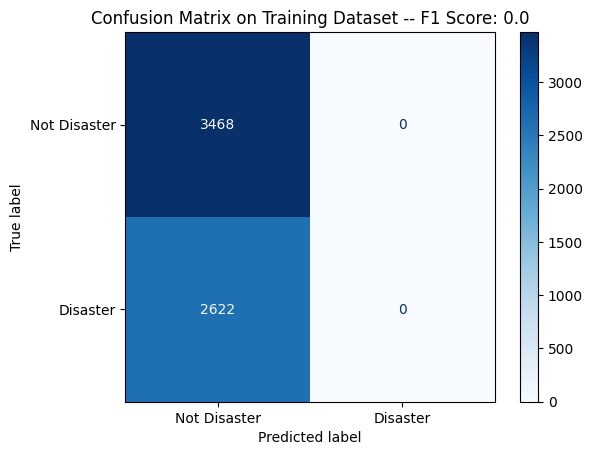

In [33]:
displayConfusionMatrix(y_train, y_pred_train, "Training")

In [ ]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

## 6- Create Submission file

In [34]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

 12/102 ━━━━━━━━━━━━━━━━━━━━ 16:28 11s/step

In [ ]:
sample_submission.describe()

In [ ]:
sample_submission.to_csv("submission_4ep.csv", index=False)